In [7]:
# python library imports
import pandas as pd
import glob
import numpy as np
import dask.dataframe as dd
import gc
import sys
import numpy as np
import pyarrow
from sklearn.model_selection import train_test_split
import sagemaker
import os
import boto3
from imblearn.over_sampling import SMOTENC

In [8]:
region = boto3.Session().region_name
role = sagemaker.get_execution_role()
sagemaker_session = sagemaker.Session()
bucket_name = sagemaker.Session().default_bucket()

prefix = 'ipinyou'
os.environ["AWS_REGION"] = region

print(f'Region : {region}')
print(f'IAM Role : {role}')
print(f'S3 Bucket : {bucket_name}')

# Get the current installed version of Sagemaker SDK, TensorFlow, Python, Boto3 and SMDebug
print(f'SageMaker Python SDK version : {sagemaker.__version__}')
print(f'Python version : {sys.version}')

Region : us-east-1
IAM Role : arn:aws:iam::725069941408:role/service-role/AmazonSageMaker-ExecutionRole-20230327T095833
S3 Bucket : sagemaker-us-east-1-725069941408
SageMaker Python SDK version : 2.140.1
Python version : 3.7.10 (default, Jun  4 2021, 14:48:32) 
[GCC 7.5.0]


In [9]:
df = pd.read_csv('usersegfull.csv',header=None)

In [10]:
df

,0,1,2,3,4,5,6,7,8,9,...,39,40,41,42,43,44,45,46,47,48
0,1,94,95,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,58,100,240
1,1,124,129,1,1,1,0,1,0,1,...,0,0,0,0,0,0,0,175,43,146
2,1,80,85,1,0,0,1,0,0,1,...,0,0,1,0,0,0,0,221,224,27
3,1,298,299,1,0,1,0,0,0,1,...,0,0,0,0,0,0,0,114,138,135
4,1,2,2,1,0,1,0,0,0,1,...,0,0,0,0,0,0,0,222,36,155
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202405,0,15,18,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,113,26,151
202406,0,15,25,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,60,221,36
202407,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,117,172,77
202408,0,164,167,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,110,197,195


In [11]:
train_data, validation_data, test_data = np.split(df.sample(frac=1, random_state=54321), [int(0.7 * len(df)), int(0.9 * len(df))])   # Randomly sort the data then split out first 70%, second 20%, and last 10%

In [10]:
train_data.to_csv('train.csv', index=False, header=False)
validation_data.to_csv('val.csv', index=False, header=False)
test_data.to_csv('test.csv', index=False, header=False)

In [11]:
sagemaker_session.upload_data('train.csv',bucket=bucket_name,key_prefix=prefix)

's3://sagemaker-us-east-1-725069941408/ipinyou/train.csv'

In [12]:
sagemaker_session.upload_data('val.csv',bucket=bucket_name,key_prefix=prefix)

's3://sagemaker-us-east-1-725069941408/ipinyou/val.csv'

In [13]:
s3_input_train = sagemaker.inputs.TrainingInput(s3_data=f's3://{bucket_name}/{prefix}/train.csv', content_type='csv')

In [14]:
s3_input_validation = sagemaker.inputs.TrainingInput(s3_data=f's3://{bucket_name}/{prefix}/val.csv', content_type='csv')

In [15]:
container = sagemaker.image_uris.retrieve(region=boto3.Session().region_name, framework='xgboost', version='latest')

In [18]:
xgb = sagemaker.estimator.Estimator(container,                                    
                                    role,
                                    instance_count=1,
                                    instance_type='ml.m5.xlarge',
                                    output_path=f's3://{bucket_name}/{prefix}/output',
                                    disable_profiler=True,
                                    sagemaker_session=sagemaker_session)

xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        silent=0,
                        objective='binary:logistic',
                        num_round=100)


xgb.fit({'train': s3_input_train, 'validation': s3_input_validation}) 

INFO:sagemaker:Creating training-job with name: xgboost-2023-04-12-18-30-59-588


2023-04-12 18:31:00 Starting - Starting the training job...
2023-04-12 18:31:17 Starting - Preparing the instances for training...
2023-04-12 18:32:02 Downloading - Downloading input data...
2023-04-12 18:32:32 Training - Downloading the training image...
2023-04-12 18:32:53 Training - Training image download completed. Training in progress.Arguments: train
[2023-04-12:18:33:03:INFO] Running standalone xgboost training.
[2023-04-12:18:33:03:INFO] File size need to be processed in the node: 18.39mb. Available memory size in the node: 8138.51mb
[2023-04-12:18:33:03:INFO] Determined delimiter of CSV input is ','
[18:33:03] S3DistributionType set as FullyReplicated
[18:33:03] 141687x48 matrix with 6800976 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2023-04-12:18:33:03:INFO] Determined delimiter of CSV input is ','
[18:33:03] S3DistributionType set as FullyReplicated
[18:33:04] 40482x48 matrix with 1943136 entries loaded from /opt/ml/input/data/valida

In [19]:
xgb_predictor = xgb.deploy(initial_instance_count=1,
                           instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: xgboost-2023-04-12-18-34-41-956
INFO:sagemaker:Creating endpoint-config with name xgboost-2023-04-12-18-34-41-956
INFO:sagemaker:Creating endpoint with name xgboost-2023-04-12-18-34-41-956


----------!

In [20]:
xgb_predictor.serializer = sagemaker.serializers.CSVSerializer()

In [21]:
test_data = pd.read_csv('test.csv')

In [23]:
def predict(data, predictor, rows=500 ):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, predictor.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')

predictions = predict(test_data.drop(['0'], axis=1).to_numpy(), xgb_predictor)

In [24]:
predictions

array([9.20872986e-01, 8.24334638e-05, 2.36104534e-04, ...,
       1.04797495e-04, 9.62273657e-01, 9.23030138e-01])

In [25]:
import matplotlib.pyplot as plt

In [40]:
plt.hist(predictions,bins=40)

(array([9.313e+03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 2.000e+00, 3.000e+00, 1.500e+01, 3.800e+01, 2.370e+02,
        1.276e+03, 4.862e+03, 4.130e+03, 3.640e+02]),
 array([3.74238880e-05, 2.46080546e-02, 4.91786853e-02, 7.37493159e-02,
        9.83199466e-02, 1.22890577e-01, 1.47461208e-01, 1.72031839e-01,
        1.96602469e-01, 2.21173100e-01, 2.45743731e-01, 2.70314361e-01,
        2.94884992e-01, 3.19455623e-01, 3.44026253e-01, 3.68596884e-01,
        3.93167515e-01, 4.17738146e-01, 4.42308776e-01, 4.66879407e-01,
        4.91450038e-01, 5.16020668e-01, 5.40591299e-01, 5.65161930e-01,
        5.89732560e-01, 6.14303191e-01, 6.38873822e-01, 6.63444452e-01

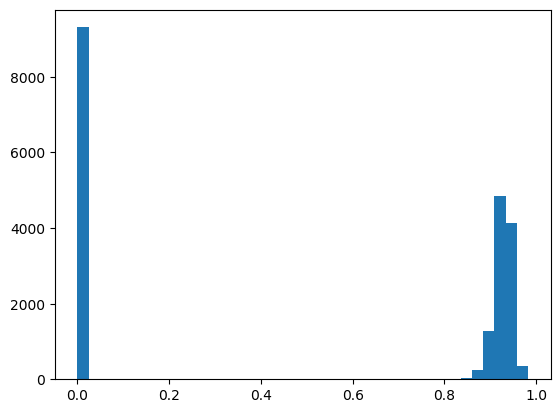

In [41]:
plt.show()